In [1]:
import random
import time
import numpy as np
import pandas as pd
import torch
from torch import nn
from tqdm import tqdm
from run import utils

C:\Users\lucas\anaconda3\envs\neuromancer\lib\site-packages\mlflow\protos\service_pb2.py:11: UserWarning: google.protobuf.service module is deprecated. RPC implementations should provide code generator plugins which generate code specific to the RPC implementation. service.py will be removed in Jan 2025
  from google.protobuf import service as _service


## 100x100 Convex Quadratic

In [2]:
# random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# init
num_var = 100     # number of variables
num_ineq = 100    # number of constraints
num_data = 10000  # number of data
test_size = 1000  # number of test size
val_size = 1000   # number of validation size
train_size = num_data - test_size - val_size


# data sample from uniform distribution
b_samples = torch.from_numpy(np.random.uniform(-1, 1, size=(num_data, num_ineq))).float()
data = {"b":b_samples}
# data split
from src.utlis import data_split
data_train, data_test, data_dev = data_split(data, test_size=test_size, val_size=val_size)

# torch dataloaders
from torch.utils.data import DataLoader
batch_size = 64
loader_train = DataLoader(data_train, batch_size, num_workers=0, collate_fn=data_train.collate_fn, shuffle=True)
loader_test = DataLoader(data_test, batch_size, num_workers=0, collate_fn=data_test.collate_fn, shuffle=False)
loader_dev = DataLoader(data_dev, batch_size, num_workers=0, collate_fn=data_dev.collate_fn, shuffle=False)

# init model
from src.problem import msQuadratic
model = msQuadratic(num_var, num_ineq, timelimit=600)

In [4]:
# get b
b = data_test.datadict["b"][0].cpu().numpy()

### Rounding Classification

In [5]:
# random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [6]:
# hyperparameters
penalty_weight = 1    # weight of constraint violation penealty
hlayers_sol = 5       # number of hidden layers for solution mapping
hlayers_rnd = 4       # number of hidden layers for solution mapping
hsize = 256           # width of hidden layers for solution mapping
lr = 1e-3             # learning rate

# set problem
import neuromancer as nm
from src.problem import nmQuadratic
from src.func.layer import netFC
from src.func import roundGumbelModel
# build neural architecture for the solution map
func = nm.modules.blocks.MLP(insize=num_ineq, outsize=num_var, bias=True,
                             linear_map=nm.slim.maps["linear"],
                             nonlin=nn.ReLU, hsizes=[hsize]*hlayers_sol)
smap = nm.system.Node(func, ["b"], ["x"], name="smap")
# define rounding model
layers_rnd = netFC(input_dim=num_ineq+num_var, hidden_dims=[hsize]*hlayers_rnd, output_dim=num_var)
rnd = roundGumbelModel(layers=layers_rnd, param_keys=["b"], var_keys=["x"],  output_keys=["x_rnd"], 
                       int_ind={"x":range(num_var)}, continuous_update=True, name="round")
# build neuromancer problem for rounding
components = nn.ModuleList([smap, rnd]).to("cuda")
loss_fn = nmQuadratic(["b", "x_rnd"], num_var, num_ineq, penalty_weight)

from src.problem.neuromancer.trainer import trainer
# training
epochs = 200                    # number of training epochs
warmup = 20                     # number of epochs to wait before enacting early stopping policy
patience = 20                   # number of epochs with no improvement in eval metric to allow before early stopping
optimizer = torch.optim.AdamW(components.parameters(), lr=lr)
# create a trainer for the problem
my_trainer = trainer(components, loss_fn, optimizer, epochs=epochs, patience=patience, warmup=warmup, device="cuda")
# training for the rounding problem
my_trainer.train(loader_train, loader_dev)

Epoch 0, Iters 0, Validation Loss: 36.34
Epoch 0, Iters 125, Training Loss: -8.36, Validation Loss: -15.03
Epoch 1, Iters 250, Training Loss: -15.82, Validation Loss: -16.31
Epoch 2, Iters 375, Training Loss: -16.15, Validation Loss: -15.28
Epoch 3, Iters 500, Training Loss: -16.47, Validation Loss: -16.42
Epoch 4, Iters 625, Training Loss: -16.55, Validation Loss: -16.22
Epoch 5, Iters 750, Training Loss: -16.80, Validation Loss: -16.01
Epoch 6, Iters 875, Training Loss: -16.87, Validation Loss: -16.51
Epoch 7, Iters 1000, Training Loss: -16.96, Validation Loss: -16.15
Epoch 8, Iters 1125, Training Loss: -17.07, Validation Loss: -16.44
Epoch 9, Iters 1250, Training Loss: -17.18, Validation Loss: -17.01
Epoch 10, Iters 1375, Training Loss: -17.34, Validation Loss: -17.26
Epoch 11, Iters 1500, Training Loss: -17.40, Validation Loss: -17.06
Epoch 12, Iters 1625, Training Loss: -17.46, Validation Loss: -17.31
Epoch 13, Iters 1750, Training Loss: -17.58, Validation Loss: -17.25
Epoch 14, I

In [7]:
# init proj
from src.postprocess.project import gradientProjection
proj = gradientProjection([components[0]], [components[1]], loss_fn, "x")
# data point as tensor
datapoints = {"b": torch.unsqueeze(torch.from_numpy(b), 0).to("cuda"), "name": "test"}
# infer
components.eval()
tick = time.time()
with torch.no_grad():
    for comp in components:
        datapoints.update(comp(datapoints))
# post-processing
proj(datapoints)
tock = time.time()
elapsed = tock - tick
# assign params
model.set_param_val({"b":b})
# assign vars
x = datapoints["x_rnd"]
for i in range(num_var):
    model.vars["x"][i].value = x[0,i].item()
# get solutions
xval, objval = model.get_val()
viol = np.mean(model.cal_violation())
print(f"Obj: {objval:.4f} with {viol:.4f} violation in {elapsed:.4f} sec.")

Obj: -20.2946 with 0.0000 violation in 0.3901 sec.


### Learnable Threshold

In [8]:
# random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [9]:
# hyperparameters
penalty_weight = 1    # weight of constraint violation penealty
hlayers_sol = 5       # number of hidden layers for solution mapping
hlayers_rnd = 4       # number of hidden layers for solution mapping
hsize = 256           # width of hidden layers for solution mapping
lr = 1e-3             # learning rate

# set problem
import neuromancer as nm
from src.problem import nmQuadratic
from src.func.layer import netFC
from src.func import roundThresholdModel
# build neural architecture for the solution map
func = nm.modules.blocks.MLP(insize=num_ineq, outsize=num_var, bias=True,
                             linear_map=nm.slim.maps["linear"],
                             nonlin=nn.ReLU, hsizes=[hsize]*hlayers_sol)
smap = nm.system.Node(func, ["b"], ["x"], name="smap")
# define rounding model
layers_rnd = netFC(input_dim=num_ineq+num_var, hidden_dims=[hsize]*hlayers_rnd, output_dim=num_var)
rnd = roundThresholdModel(layers=layers_rnd, param_keys=["b"], var_keys=["x"],  output_keys=["x_rnd"], 
                       int_ind=model.int_ind, continuous_update=True, name="round")
# build neuromancer problem for rounding
components = nn.ModuleList([smap, rnd]).to("cuda")
loss_fn = nmQuadratic(["b", "x_rnd"], num_var, num_ineq, penalty_weight)

from src.problem.neuromancer.trainer import trainer
# training
epochs = 200                    # number of training epochs
warmup = 20                     # number of epochs to wait before enacting early stopping policy
patience = 20                   # number of epochs with no improvement in eval metric to allow before early stopping
optimizer = torch.optim.AdamW(components.parameters(), lr=lr)
# create a trainer for the problem
my_trainer = trainer(components, loss_fn, optimizer, epochs=epochs, patience=patience, warmup=warmup, device="cuda")
# training for the rounding problem
my_trainer.train(loader_train, loader_dev)

Epoch 0, Iters 0, Validation Loss: 24.85
Epoch 0, Iters 125, Training Loss: -9.25, Validation Loss: -16.58
Epoch 1, Iters 250, Training Loss: -17.13, Validation Loss: -16.60
Epoch 2, Iters 375, Training Loss: -17.38, Validation Loss: -16.67
Epoch 3, Iters 500, Training Loss: -17.46, Validation Loss: -17.04
Epoch 4, Iters 625, Training Loss: -17.60, Validation Loss: -17.44
Epoch 5, Iters 750, Training Loss: -17.85, Validation Loss: -16.94
Epoch 6, Iters 875, Training Loss: -17.95, Validation Loss: -17.25
Epoch 7, Iters 1000, Training Loss: -18.01, Validation Loss: -16.79
Epoch 8, Iters 1125, Training Loss: -18.12, Validation Loss: -16.82
Epoch 9, Iters 1250, Training Loss: -18.19, Validation Loss: -17.96
Epoch 10, Iters 1375, Training Loss: -18.27, Validation Loss: -18.22
Epoch 11, Iters 1500, Training Loss: -18.29, Validation Loss: -17.94
Epoch 12, Iters 1625, Training Loss: -18.39, Validation Loss: -17.94
Epoch 13, Iters 1750, Training Loss: -18.48, Validation Loss: -18.24
Epoch 14, I

In [10]:
# init proj
from src.postprocess.project import gradientProjection
proj = gradientProjection([components[0]], [components[1]], loss_fn, "x")
# data point as tensor
datapoints = {"b": torch.unsqueeze(torch.from_numpy(b), 0).to("cuda"), "name": "test"}
# infer
components.eval()
tick = time.time()
with torch.no_grad():
    for comp in components:
        datapoints.update(comp(datapoints))
# post-processing
proj(datapoints)
tock = time.time()
elapsed = tock - tick
# assign params
model.set_param_val({"b":b})
# assign vars
x = datapoints["x_rnd"]
for i in range(num_var):
    model.vars["x"][i].value = x[0,i].item()
# get solutions
xval, objval = model.get_val()
viol = np.mean(model.cal_violation())
print(f"Obj: {objval:.4f} with {viol:.4f} violation in {elapsed:.4f} sec.")

Obj: -20.0836 with 0.0000 violation in 0.5117 sec.


### Exact Solver

In [10]:
# random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [11]:
# set n
model.set_param_val({"b":b})
# solve
xval, objval = model.solve("gurobi", tee=True, keepfiles=True)

Solver script file: 'C:\Users\lucas\AppData\Local\Temp\tmpngu7okky.gurobi.script'
Solver log file: 'C:\Users\lucas\AppData\Local\Temp\tmp2uxkdxe6.gurobi.log'
Solver solution file: 'C:\Users\lucas\AppData\Local\Temp\tmpcwvkhpgt.gurobi.txt'
Solver problem files: ('C:\\Users\\lucas\\AppData\\Local\\Temp\\tmpn3su24zw.pyomo.lp',)
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-25
Read LP format model from file C:\Users\lucas\AppData\Local\Temp\tmpn3su24zw.pyomo.lp
Reading time = 0.01 seconds
x1: 100 rows, 100 columns, 10000 nonzeros
Set parameter TimeLimit to value 600
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: AMD Ryzen 7 5800HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 100 rows, 100 columns and 10000 nonzeros
Model fingerprint: 0x022e99b5
Model has 100 quadratic objective terms
Variable 

### Plot

In [4]:
import os
import warnings

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scienceplots
plt.style.reload_library()
plt.style.use("science")
from matplotlib import ticker
import tol_colors as tc
cset =  tc.tol_cset("medium-contrast")
from brokenaxes import brokenaxes

In [5]:
def plotObj(times, objs):
    # prepare data for step-like plot
    time_steps = []
    obj_steps = []
    for i in range(len(times)):
        if i > 0:
            time_steps.append(times[i])  # add the current time
            obj_steps.append(objs[i - 1])  # previous obj value
        time_steps.append(times[i])  # add the current time
        obj_steps.append(objs[i])  # current obj value
    # create subplots for a broken y-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 4), gridspec_kw={"height_ratios":[2, 8]}) 
    ax1.step(time_steps, np.array(obj_steps)/1e17, where='post', linewidth=4, color=cset.light_yellow)
    ax1.set_ylim(objs[0]/1e17 - 0.5, objs[0]/1e17 + 0.5)
    ax1.spines["bottom"].set_visible(False)
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x * 1e17:.1e}"))
    ax1.tick_params(labelbottom=False)  # hide x-axis labels for the top plot
    # plot for the bottom (detailed range)
    ax2.step(time_steps, obj_steps, where="post", linewidth=4, color=cset.light_yellow, label="EX (Gurobi)")
    ax2.scatter(0.3901, -20.2946-0.1, s=200, color=cset.dark_blue, label="RC-P", zorder=8)
    ax2.scatter(0.0040, -20.0836+0.1, s=200, color=cset.dark_red, label="LT-P", zorder=8)
    ax2.set_ylim(-22, 0)
    ax2.spines['top'].set_visible(False)
    # diagonal lines to indicate the break
    d = 0.015  # Size of diagonal lines
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
    kwargs.update(transform=ax2.transAxes)
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    plt.tight_layout()
    # grid
    plt.grid(color="grey", alpha=0.5, linewidth=0.5, which="major", axis="y")
    # style
    ax1.set_title("An Instance on 100×100 Quadratic", fontsize=36)
    ax1.set_yticks([objs[0] / 1e17])
    ax1.grid(color="grey", alpha=0.5, linewidth=0.5, which="major", axis="y")
    ax2.grid(color="grey", alpha=0.5, linewidth=0.5, which="major", axis="y")
    ax2.set_xlabel("Time (Second)", fontsize=32)
    ax2.set_ylabel("Objective Value", fontsize=32)
    ax1.tick_params(axis="both", labelsize=24)
    ax2.tick_params(axis="both", labelsize=24)
    ax2.legend(title="Method", fontsize=24, title_fontsize=24)
    plt.savefig("./img/solving_cq.pdf", dpi=300)

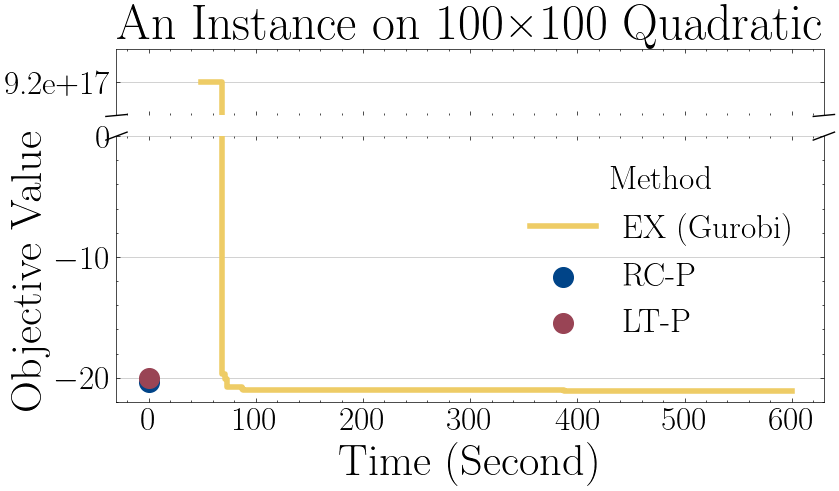

In [6]:
times = [49, 68, 71, 73, 76, 87, 88, 90, 388, 600] 
objs = [9.2105e+17, -19.6837120, -20.1223765, -20.7598846, -20.7815701, -20.9265157, -21.0435634, -21.04356, -21.1332911, -21.13329]
plotObj(times, objs)